In [1]:
%config Completer.use_jedi = False
%matplotlib inline

import os
import sys
import pytz
from datetime import datetime
import geopandas as gpd

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from glob import glob
from shapely.geometry import Point, Polygon
from collections import Counter
from dask.distributed import Client

from sklearn.metrics import r2_score
from sklearn.linear_model import LinearRegression
from mpl_toolkits.axes_grid1 import make_axes_locatable

import mobilkit

## Notebook to compare, for each area, the number of people living there

We reload the results of the home/work analysis done in the `01_mobilkit_example.ipynb` to see the number of people living in an area as found in the data and compare it with census figures.

---
**NOTE**

When determining the home location of a user, please consider that some data providers, like _Cuebiq_, obfuscate/obscure/alter the coordinates of the points falling near the user's home location in order to preserve his privacy.

This means that you cannot locate the precise home of a user with a spatial resolution higher than the one used to obfuscate these data. If you are interested in the census area (or geohash) of the user's home alone and you are using a spatial tessellation with a spatial resolution wider than or equal to the one used to obfuscate the data, then this is of no concern.

However, tasks such as stop-detection or POI visit rate computation may be affected by the noise added to data in the user's home location area.

Please check if your data has such noise added and choose the spatial tessellation according to your use case.

---

### Load the results of our analysis

In [2]:
df_hw_locs_pd = pd.read_pickle("../data/home_work_location_counts.pkl")
df_hw_locs_pd.columns

Index(['uid', 'pings_home', 'home_tile_ID', 'lat_home', 'lng_home',
       'pings_work', 'work_tile_ID', 'lat_work', 'lng_work'],
      dtype='object')

In [3]:
population_per_area = df_hw_locs_pd.groupby("home_tile_ID").agg({
                                                "uid": "nunique",
                                                "pings_home": "sum"}).reset_index()

population_per_area = population_per_area.rename(columns={
                                                "home_tile_ID": "tile_ID",
                                                "uid": "POP_HFLB",
                                                "pings_home": "pings"})

## Reload the shapefile

And merge the HFLB count of residents with the shapefile.

In [4]:
shape_file = "../data/sample_shape/mexico_selection_epicentre.shp"

gdf_areas = gpd.read_file(shape_file)
if "path" in gdf_areas:
    del gdf_areas["path"]
gdf_areas.head(2)

/data/Sandbox_HOME/mobenv/lib/python3.9/site-packages/geopandas-0.8.2-py3.9.egg/geopandas/_vectorized.py:143: ShapelyDeprecationWarning: __len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the `geoms` property instead to get the  number of parts of a multi-part geometry.
  aout[:] = out


,CVE_ENT,CVE_LOC,CVE_MUN,CVE_AGEB,CVEGEO,layer,ZONE_IDX,tile_ID,geometry
0,12,0039,055,0730,None,12a,0,0,"POLYGON ((-99.54281 18.60610, -99.54198 18.606..."
1,12,0001,049,0057,None,12a,1,1,"POLYGON ((-99.67015 18.74569, -99.66967 18.744..."


In [5]:
gdf_areas = pd.merge(gdf_areas, population_per_area, on="tile_ID", how="left")
gdf_areas["POP_HFLB"] = gdf_areas["POP_HFLB"].fillna(0)

## Load the census files

These contains the locations per area.

These are per state data from the 2010 census of the INEGI. See [here](https://www.inegi.org.mx/rnm/index.php/catalog/71) for details.

In [6]:
# Load CSV with pop...
csv_files = glob("../data/census_population/RESAGEBURB_*TXT10.txt")

df_pop = pd.DataFrame()
for f in csv_files:
    tmp_df = pd.read_csv(f, sep="\t", encoding="latin-1")
    
    df_pop = pd.concat((df_pop,tmp_df), ignore_index=True, sort=True)
    print(f)

../data/census_population/RESAGEBURB_15TXT10.txt
../data/census_population/RESAGEBURB_21TXT10.txt
../data/census_population/RESAGEBURB_29TXT10.txt
../data/census_population/RESAGEBURB_09TXT10.txt
../data/census_population/RESAGEBURB_17TXT10.txt
../data/census_population/RESAGEBURB_13TXT10.txt


In [7]:
df_pop.head()

,AGEB,ENTIDAD,GRAPROES,GRAPROES_F,GRAPROES_M,HOGJEF_F,HOGJEF_M,LOC,MUN,MZA,...,VPH_NODREN,VPH_PC,VPH_PISODT,VPH_PISOTI,VPH_RADIO,VPH_REFRI,VPH_SNBIEN,VPH_S_ELEC,VPH_TELEF,VPH_TV
0,0000,15,9.10,8.88,9.33,847910,2841143,0,0,0,...,194169,1162156,3527805,138658,3165441,2929118,50484,30053,1852506,3538214
1,0000,15,6.85,6.59,7.13,3122,11057,0,1,0,...,5727,1180,13180,948,10051,6983,1132,665,2600,12011
2,0000,15,10.76,10.62,10.93,285,733,1,1,0,...,27,414,996,18,782,807,10,5,563,988
3,0127,15,11.07,10.81,11.38,202,482,1,1,0,...,0,279,667,13,509,556,7,4,414,665
4,0127,15,0,0,0,0,0,1,1,1,...,0,0,0,0,0,0,0,0,0,0


In [8]:
# Save the totals for the different partitions
pop_localidades = df_pop[df_pop["NOM_LOC"] == "Total de la localidad urbana"].copy()
pop_municipios = df_pop[df_pop["NOM_LOC"] == "Total del municipio"].copy()
pop_AGEB = df_pop[df_pop["NOM_LOC"] == "Total AGEB urbana"].copy()

In [9]:
pop_municipios.shape, pop_localidades.shape, pop_AGEB.shape

((410, 199), (1347, 199), (11732, 199))

In [10]:
pop_municipios.head(2)

,AGEB,ENTIDAD,GRAPROES,GRAPROES_F,GRAPROES_M,HOGJEF_F,HOGJEF_M,LOC,MUN,MZA,...,VPH_NODREN,VPH_PC,VPH_PISODT,VPH_PISOTI,VPH_RADIO,VPH_REFRI,VPH_SNBIEN,VPH_S_ELEC,VPH_TELEF,VPH_TV
121938,0000,21,6.25,6.05,6.47,2374,9637,0,1,0,...,1680,867,11386,583,9111,6088,574,269,3282,10740
123004,0000,21,6.03,5.84,6.21,418,1852,0,2,0,...,502,79,1664,603,1469,1503,122,117,468,2022


Now we combine the code of the areas to build the unique mapping between `CVEGEO` and the municipio, localidad and AGEB codes.

In [11]:
urban_areas_gdf = gdf_areas[~gdf_areas["CVE_LOC"].isna()].copy()
urban_areas_gdf.shape, gdf_areas.shape

pop_AGEB["CVEGEO"] = pop_AGEB[["ENTIDAD","MUN","LOC","AGEB"]].apply(lambda ss:
                    "%02d%03d%04d%s" % tuple(ss), axis=1)

urban_areas_gdf["CVEGEO"] = urban_areas_gdf[["CVE_ENT","CVE_MUN","CVE_LOC","CVE_AGEB"]]\
                            .apply(lambda ss:
                                        "%s%s%s%s" % tuple(ss), axis=1)

print(urban_areas_gdf.shape)
urban_areas_gdf = pd.merge(urban_areas_gdf, pop_AGEB[["CVEGEO","POBTOT"]],
                           on="CVEGEO", how="left")
print(urban_areas_gdf.shape)

(10550, 11)
(10550, 12)


In [12]:
# Save to a csv
urban_areas_gdf.to_csv("../data/population_estimate_mexico.csv")

# Plot the correlations between HFLB data and census figures

---
**NOTE**
We divide the population of the HFLB data by its total to preserve the origial dataset's statistics.
---


## By AGEB

In [13]:
urban_areas_gdf["POP_DENSITY_HFLB"] = urban_areas_gdf["POP_HFLB"] / urban_areas_gdf["POP_HFLB"].sum()

In [14]:
sns.set_context("notebook", font_scale=1.5)

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.075
Model:                            OLS   Adj. R-squared:                  0.074
Method:                 Least Squares   F-statistic:                     352.2
Date:                Mon, 21 Jun 2021   Prob (F-statistic):           1.25e-75
Time:                        11:21:06   Log-Likelihood:                -208.40
No. Observations:                4369   AIC:                             420.8
Df Residuals:                    4367   BIC:                             433.6
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -4.5298      0.042   -108.677      0.0

(1e-05, 0.05)

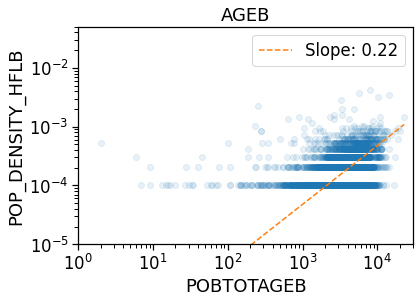

In [15]:
mobilkit.viz.plot_pop(urban_areas_gdf, "AGEB", data_pop="POP_DENSITY_HFLB")
plt.xlim(1e0, 3e4)
plt.ylim(1e-5, 5e-2)

## By LOC

In [16]:
urban_areas_gdf["CVEGEO_LOC"] = urban_areas_gdf["CVEGEO"].apply(lambda s: s[:-4])
urban_areas_gdf["CVEGEO_MUN"] = urban_areas_gdf["CVEGEO_LOC"].apply(lambda s: s[:-4])

In [17]:
pd.to_pickle(urban_areas_gdf, "../data/population_gdf_selection_epicenter.pkl")

In [18]:
urban_areas_loc_gdf = urban_areas_gdf.groupby("CVEGEO_LOC").agg({
        "POP_HFLB": "sum",
        "POP_DENSITY_HFLB": "sum",
        "POBTOT": "sum",
        "CVEGEO_MUN": "first",
        "CVE_LOC": "first",
        "CVE_ENT": "first",
        "CVE_MUN": "first",
    }).reset_index()

urban_areas_mun_gdf = urban_areas_gdf.groupby("CVEGEO_MUN").agg({
        "POP_HFLB": "sum",
        "POP_DENSITY_HFLB": "sum",
        "POBTOT": "sum",
        "CVE_ENT": "first",
        "CVE_MUN": "first",
    }).reset_index()

In [19]:
urban_areas_gdf["LOC_CODE"] = urban_areas_gdf.apply(
    lambda r: str("%s%s%s"
                  %(r["CVE_ENT"],r["CVE_MUN"],r["CVE_LOC"])), axis=1)

loc_areas = urban_areas_gdf.dissolve("LOC_CODE", aggfunc="sum")

/data/Sandbox_HOME/mobenv/lib/python3.9/site-packages/geopandas-0.8.2-py3.9.egg/geopandas/_vectorized.py:143: ShapelyDeprecationWarning: __len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the `geoms` property instead to get the  number of parts of a multi-part geometry.
  aout[:] = out


/data/Sandbox_HOME/mobenv/lib/python3.9/site-packages/geopandas-0.8.2-py3.9.egg/geopandas/plotting.py:49: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for poly in geom:
/data/Sandbox_HOME/mobenv/lib/python3.9/site-packages/descartes-1.1.0-py3.9.egg/descartes/patch.py:62: ShapelyDeprecationWarning: The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.
  vertices = concatenate([
/data/Sandbox_HOME/mobenv/lib/python3.9/site-packages/descartes-1.1.0-py3.9.egg/descartes/patch.py:64: ShapelyDeprecationWarning: The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.
  [asarray(r)[:, :2] for r in t.interiors])


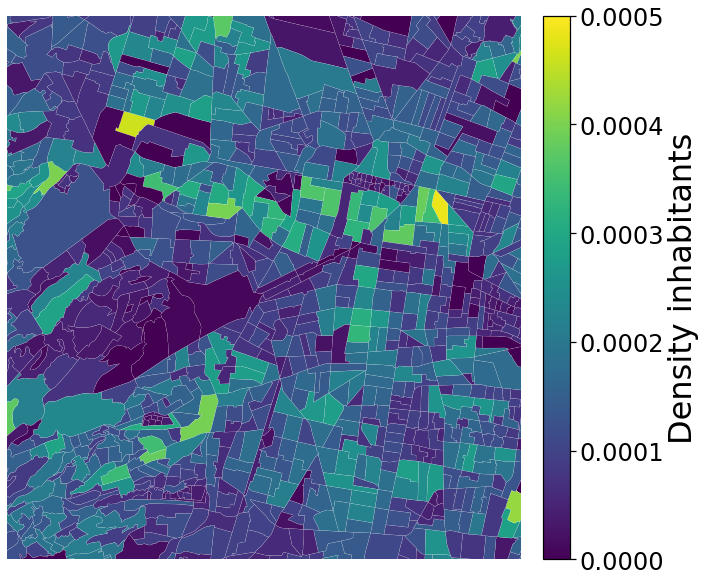

In [20]:
# We plot census population estimates not to disclose original dataset statistics
fig, ax = plt.subplots(1,1,figsize=(12,10))
ax.set_aspect("equal")
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.1)

tmp = urban_areas_gdf.copy()
tmp = tmp[tmp.is_valid]
tmp["POBTOT"].fillna(0, inplace=True)

tmp["POBTOT"].fillna(0, inplace=True)
tmp["POP_DENSITY"] = tmp["POBTOT"] / tmp["POBTOT"].sum()
tmp.plot("POP_DENSITY", ax=ax, vmin=0, vmax=.0005, legend=True,
         edgecolor="white", lw=.1, cax=cax)
ax.set_xlim(-99.25,-99.1)
ax.set_ylim(19.35,19.5)

ax.axis("off")

cax.set_ylabel("Density inhabitants", size=32)
cax.tick_params(labelsize=24)

In [21]:
# Table-preview not shown so as not to disclose original dataset statistics
OD_home_work = df_hw_locs_pd.groupby(["home_tile_ID","work_tile_ID"]).agg({"uid": "nunique"})
OD_home_work = OD_home_work.rename(columns={"uid": "Volume"})
# OD_home_work.head()

## And by LOC

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.766
Model:                            OLS   Adj. R-squared:                  0.766
Method:                 Least Squares   F-statistic:                     1535.
Date:                Mon, 21 Jun 2021   Prob (F-statistic):          7.01e-150
Time:                        11:22:26   Log-Likelihood:                -113.13
No. Observations:                 470   AIC:                             230.3
Df Residuals:                     468   BIC:                             238.6
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -7.3266      0.098    -74.993      0.0

<ipython-input-22-a5fe8bae5b87>:34: UserWarning: Attempted to set non-positive left xlim on a log-scaled axis.
Invalid limit will be ignored.
  plt.xlim(urban_areas_loc_gdf["POBTOT"].min()/10., urban_areas_loc_gdf["POBTOT"].max()*2.)
<ipython-input-22-a5fe8bae5b87>:35: UserWarning: Attempted to set non-positive bottom ylim on a log-scaled axis.
Invalid limit will be ignored.
  plt.ylim(urban_areas_loc_gdf["POP_DENSITY_HFLB"].min()/10., urban_areas_loc_gdf["POP_DENSITY_HFLB"].max()*2.)


Text(0, 0.5, 'Pop density HFLB')

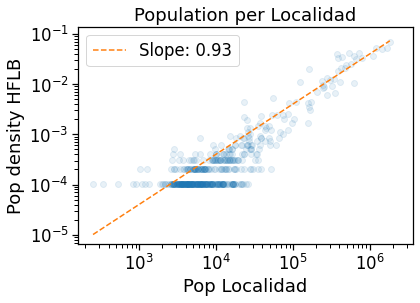

In [22]:
plt.scatter(urban_areas_loc_gdf["POBTOT"], urban_areas_loc_gdf["POP_DENSITY_HFLB"], alpha=.1)
plt.loglog();

lr = LinearRegression(fit_intercept=False)

valid = urban_areas_loc_gdf[(~urban_areas_loc_gdf["POBTOT"].isna())
                      & (~urban_areas_loc_gdf["POP_DENSITY_HFLB"].isna())]

X = valid["POBTOT"].values
Y = valid["POP_DENSITY_HFLB"].values

idxs = np.logical_and(X>0,Y>0)
X = X[idxs]
Y = Y[idxs]

lr.fit(X.reshape(-1,1),
       Y.reshape(-1,1))

X_pred = np.array(sorted(X)).reshape(-1,1)
Y_pred = lr.predict(X_pred)

import statsmodels.api as sm
from scipy import stats

X2 = sm.add_constant(np.log10(X))
est = sm.OLS(np.log10(Y), X2)
est2 = est.fit()

print(est2.summary())

plt.plot(X_pred, Y_pred, "--C1", label="Slope: %.02f"
         % (est2.params[1]))

plt.xlim(urban_areas_loc_gdf["POBTOT"].min()/10., urban_areas_loc_gdf["POBTOT"].max()*2.)
plt.ylim(urban_areas_loc_gdf["POP_DENSITY_HFLB"].min()/10., urban_areas_loc_gdf["POP_DENSITY_HFLB"].max()*2.)

plt.title("Population per Localidad")
plt.legend()
plt.xlabel("Pop Localidad")
plt.ylabel("Pop density HFLB")